In [1]:
import os
from typing import Optional
import sys

sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Third-party data science & visualization
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm.autonotebook import tqdm

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchvision
from torchvision import models
from torchvision.transforms import v2 as transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Torchmetrics
import torchmetrics
from torchmetrics import MetricCollection

# Local application imports
from dataset import Cub2011Dataset, create_dataloaders
from pl_module import LitResNet
from eval_utils import *

/tmp/tmp.5jEkC7aQVQ/ipykernel_1665667/4260434368.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Only FC FT

In [5]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 448 

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.TrivialAugmentWide(), 
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


CUB_ROOT = '../data/CUB_200_2011/'
BATCH_SIZE = 64

train_loader, test_loader = create_dataloaders(
    root_dir=CUB_ROOT,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size=BATCH_SIZE,
    use_bbox=True,
    num_workers=10
)

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
import os
import wandb
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from datetime import datetime
from pathlib import Path

# ==== Hyperparameters ====
data_dir       = '../data/CUB_200_2011/'
batch_size     = BATCH_SIZE
num_workers    = 10
max_epochs     = 20
use_bbox       = True

lr             = 1e-3
weight_decay   = 1e-5
pretrained     = True

wandb_project  = "cub200"
wandb_run_name = "resnet50-notebook-frozen-backbone"

ckpt_dir       = "../results/checkpoints"

# ==== Setup ====
os.makedirs(ckpt_dir, exist_ok=True)
pl.seed_everything(42, workers=True)

run_dt = datetime.now().isoformat().split(".")[0]
run_name = f"{wandb_run_name}-{run_dt}"

save_dir = Path(ckpt_dir)
save_path = save_dir / run_name

save_path.mkdir(parents=True, exist_ok=True)


[rank: 0] Seed set to 42


In [8]:
model = LitResNet(
    num_classes=200,
    lr=lr,
    weight_decay=weight_decay,
    pretrained=pretrained,
)

wandb_logger = WandbLogger(
    project=wandb_project,
    name=run_name,
    log_model=True,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=str(save_path),
    monitor="val_F1Score",
    mode="max",
    save_top_k=1,
    filename="best-{epoch:02d}",
    save_last=True,
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

wandb.finish()

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cpsc4710_us79/.conda/envs/project/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: usiam_ to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
409 K     Trainable params
23.5 M    Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s]

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 94/94 [00:50<00:00,  1.84it/s, v_num=dypm, val_loss=1.980, val_Accuracy=0.539, val_F1Score=0.539, train_loss=1.090, train_Accuracy=0.853, train_F1Score=0.853] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s, v_num=dypm, val_loss=1.980, val_Accuracy=0.539, val_F1Score=0.539, train_loss=1.090, train_Accuracy=0.853, train_F1Score=0.853]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_AveragePrecision,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇█████
train_F1Score,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_Precision,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_Recall,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
val_Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
+5,...


### Full FT

In [ ]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 448 


train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.TrivialAugmentWide(), 
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


CUB_ROOT = '../data/CUB_200_2011/'
BATCH_SIZE = 64

train_loader, test_loader = create_dataloaders(
    root_dir=CUB_ROOT,
    train_transform=train_transform,
    test_transform=val_transform,
    batch_size=BATCH_SIZE,
    use_bbox=True,
    num_workers=10
)

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
import os
import wandb
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from datetime import datetime
from pathlib import Path

data_dir       = '../data/CUB_200_2011/'
batch_size     = BATCH_SIZE
num_workers    = 10
max_epochs     = 20
use_bbox       = True

lr             = 5e-4
weight_decay   = 1e-4
pretrained     = True

wandb_project  = "cub200"
wandb_run_name = "resnet50-notebook-full-ft"

ckpt_dir       = "../results/checkpoints"

os.makedirs(ckpt_dir, exist_ok=True)
pl.seed_everything(42, workers=True)

run_dt = datetime.now().isoformat().split(".")[0]
run_name = f"{wandb_run_name}-{run_dt}"

save_dir = Path(ckpt_dir)
save_path = save_dir / run_name

save_path.mkdir(parents=True, exist_ok=True)


[rank: 0] Seed set to 42


In [6]:
model = LitResNet(
    num_classes=200,
    lr=lr,
    weight_decay=weight_decay,
    pretrained=False,
)

for param in model.parameters():
    param.requires_grad = True

wandb_logger = WandbLogger(
    project=wandb_project,
    name=run_name,
    log_model=True,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=str(save_path),
    monitor="val_F1Score",
    mode="max",
    save_top_k=1,
    filename="best-{epoch:02d}",
    save_last=True,
)


lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

wandb.finish()

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cpsc4710_us79/.conda/envs/project/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: usiam_ to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s]

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 94/94 [01:22<00:00,  1.14it/s, v_num=c7uv, val_loss=0.668, val_Accuracy=0.844, val_F1Score=0.845, train_loss=0.0657, train_Accuracy=0.987, train_F1Score=0.987]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [01:23<00:00,  1.13it/s, v_num=c7uv, val_loss=0.668, val_Accuracy=0.844, val_F1Score=0.845, train_loss=0.0657, train_Accuracy=0.987, train_F1Score=0.987]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr-AdamW,████████████▁▁▁▁▁▁▁▁
train_Accuracy,▁▄▆▇▇▇▇▇▇▇██████████
train_AveragePrecision,▁▅▆▇▇▇██████████████
train_F1Score,▁▄▆▇▇▇▇▇▇▇██████████
train_Precision,▁▄▆▆▇▇▇▇▇▇██████████
train_Recall,▁▄▆▇▇▇▇▇▇▇██████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_Accuracy,▁▄▆▆▆▇▆▇▇▇▇▇████████
+5,...


### Two Stage FT

#### Stage 1

In [ ]:
import os
import torch
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torchvision import transforms
from datetime import datetime
from pathlib import Path
from torchvision.transforms import v2 as transforms


MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 448 


train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.TrivialAugmentWide(), 
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


CUB_ROOT = '../data/CUB_200_2011/'
BATCH_SIZE = 64 

train_loader, test_loader = create_dataloaders(
    root_dir=CUB_ROOT,
    train_transform=train_transform,
    test_transform=val_transform,
    batch_size=BATCH_SIZE,
    use_bbox=True,
    num_workers=10
)




/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
[rank: 0] Seed set to 42
/home/cpsc4710_us79/.local/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cpsc4710_us79/.conda/envs/project/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🚀 Starting Stage 1 Training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
409 K     Trainable params
23.5 M    Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 94/94 [00:50<00:00,  1.84it/s, v_num=2211, val_loss=1.980, val_Accuracy=0.539, val_F1Score=0.539, train_loss=1.090, train_Accuracy=0.853, train_F1Score=0.853] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s, v_num=2211, val_loss=1.980, val_Accuracy=0.539, val_F1Score=0.539, train_loss=1.090, train_Accuracy=0.853, train_F1Score=0.853]

✅ Stage 1 Finished.
➡️ Run ID to resume: jp2u2211
➡️ Checkpoint to load: /nfs/roberts/project/cpsc4710/cpsc4710_us79/Project/checkpoints/resnet50-notebook-two-stage-2025-11-20T13:54:32/stage1-best-epoch=19.ckpt


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_Accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_AveragePrecision,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇█████
train_F1Score,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_Precision,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_Recall,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
+5,...


In [ ]:
pl.seed_everything(42, workers=True)
run_dt = datetime.now().isoformat().split(".")[0]
wandb_run_name = "resnet50-notebook-two-stage"
run_name = f"{wandb_run_name}-{run_dt}"


ckpt_dir = "../results/checkpoints"
save_dir = Path(ckpt_dir) / run_name
save_dir.mkdir(parents=True, exist_ok=True)


model = LitResNet(num_classes=200, lr=1e-3, weight_decay=1e-5, pretrained=True)


wandb_logger = WandbLogger(
    project="cub200",
    name=run_name,
    log_model=True,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=str(save_dir),
    monitor="val_F1Score",
    mode="max",
    save_top_k=1,
    filename="stage1-best-{epoch:02d}",
    save_last=True,
)

trainer_stage1 = pl.Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, LearningRateMonitor("epoch")],
    log_every_n_steps=10,
)


print("Starting Stage 1 Training...")
trainer_stage1.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

prev_run_id = wandb.run.id
prev_run_path = checkpoint_callback.best_model_path
batches_per_epoch = len(train_loader)
stage1_epochs = trainer_stage1.current_epoch + 1

print(f"\n Stage 1 Finished.")
print(f"Run ID to resume: {prev_run_id}")
print(f"Checkpoint to load: {prev_run_path}")

wandb.finish()

#### Stage 2

In [ ]:
print(f"Loading checkpoint: {prev_run_path}")
model = LitResNet.load_from_checkpoint(checkpoint_path=prev_run_path)

for param in model.parameters():
    param.requires_grad = True
print("Model Unfrozen: All layers trainable.")


model.hparams.lr = 5e-4
model.hparams.weight_decay = 1e-4


wandb_logger = WandbLogger(
    project="cub200",
    id=prev_run_id,
    resume="must",
    log_model=True,
)

stage2_save_path = save_dir / "stage2"
stage2_save_path.mkdir(exist_ok=True)

checkpoint_callback_s2 = ModelCheckpoint(
    dirpath=str(stage2_save_path),
    monitor="val_F1Score",
    mode="max",
    save_top_k=1,
    filename="stage2-best-{epoch:02d}",
    save_last=True,
)


trainer_stage2 = pl.Trainer(
    max_epochs=40,   
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback_s2, LearningRateMonitor("epoch")],
    log_every_n_steps=10,
)

global_step_offset = batches_per_epoch * stage1_epochs
trainer_stage2.fit_loop.epoch_loop._batches_that_stepped = global_step_offset

print(f"Resuming Step Counter at: {global_step_offset}")

print("Starting Stage 2 (Full Fine-Tuning)...")
trainer_stage2.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

wandb.finish()

📥 Loading checkpoint: /nfs/roberts/project/cpsc4710/cpsc4710_us79/Project/checkpoints/resnet50-notebook-two-stage-2025-11-20T13:54:32/stage1-best-epoch=19.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🔓 Model Unfrozen: All layers trainable.
🔄 Resuming Step Counter at: 1974
🚀 Starting Stage 2 (Full Fine-Tuning)...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s]

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Epoch 33: 100%|██████████| 94/94 [00:58<00:00,  1.61it/s, v_num=2211, val_loss=0.876, val_Accuracy=0.810, val_F1Score=0.810, train_loss=0.0277, train_Accuracy=0.993, train_F1Score=0.993]

### Best Model Eval

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

#### Load model and transforms

In [4]:
from torchvision.transforms import v2 as transforms
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 448 

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.TrivialAugmentWide(), 
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


CUB_ROOT = '../data/CUB_200_2011/'
BATCH_SIZE = 64

train_loader, test_loader = create_dataloaders(
    root_dir=CUB_ROOT,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size=BATCH_SIZE,
    use_bbox=True,
    num_workers=10
)

train_dataset, test_dataset = train_loader.dataset, test_loader.dataset
class_names = train_dataset.class_names

/home/cpsc4710_us79/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
model = LitResNet.load_from_checkpoint(
    checkpoint_path='/home/cpsc4710_us79/project_cpsc4710/cpsc4710_us79/Project/results/checkpoints/resnet50-notebook-full-ft-2025-11-20T13:24:21/best-epoch=17.ckpt',
)
device='cuda'

#### Best Model Confusion Matrix and Metrics

In [6]:
true_labels, pred_labels, y_prob, y_logits = get_all_preds_and_probs(model, test_loader)


100%|██████████| 91/91 [00:20<00:00,  4.35it/s]


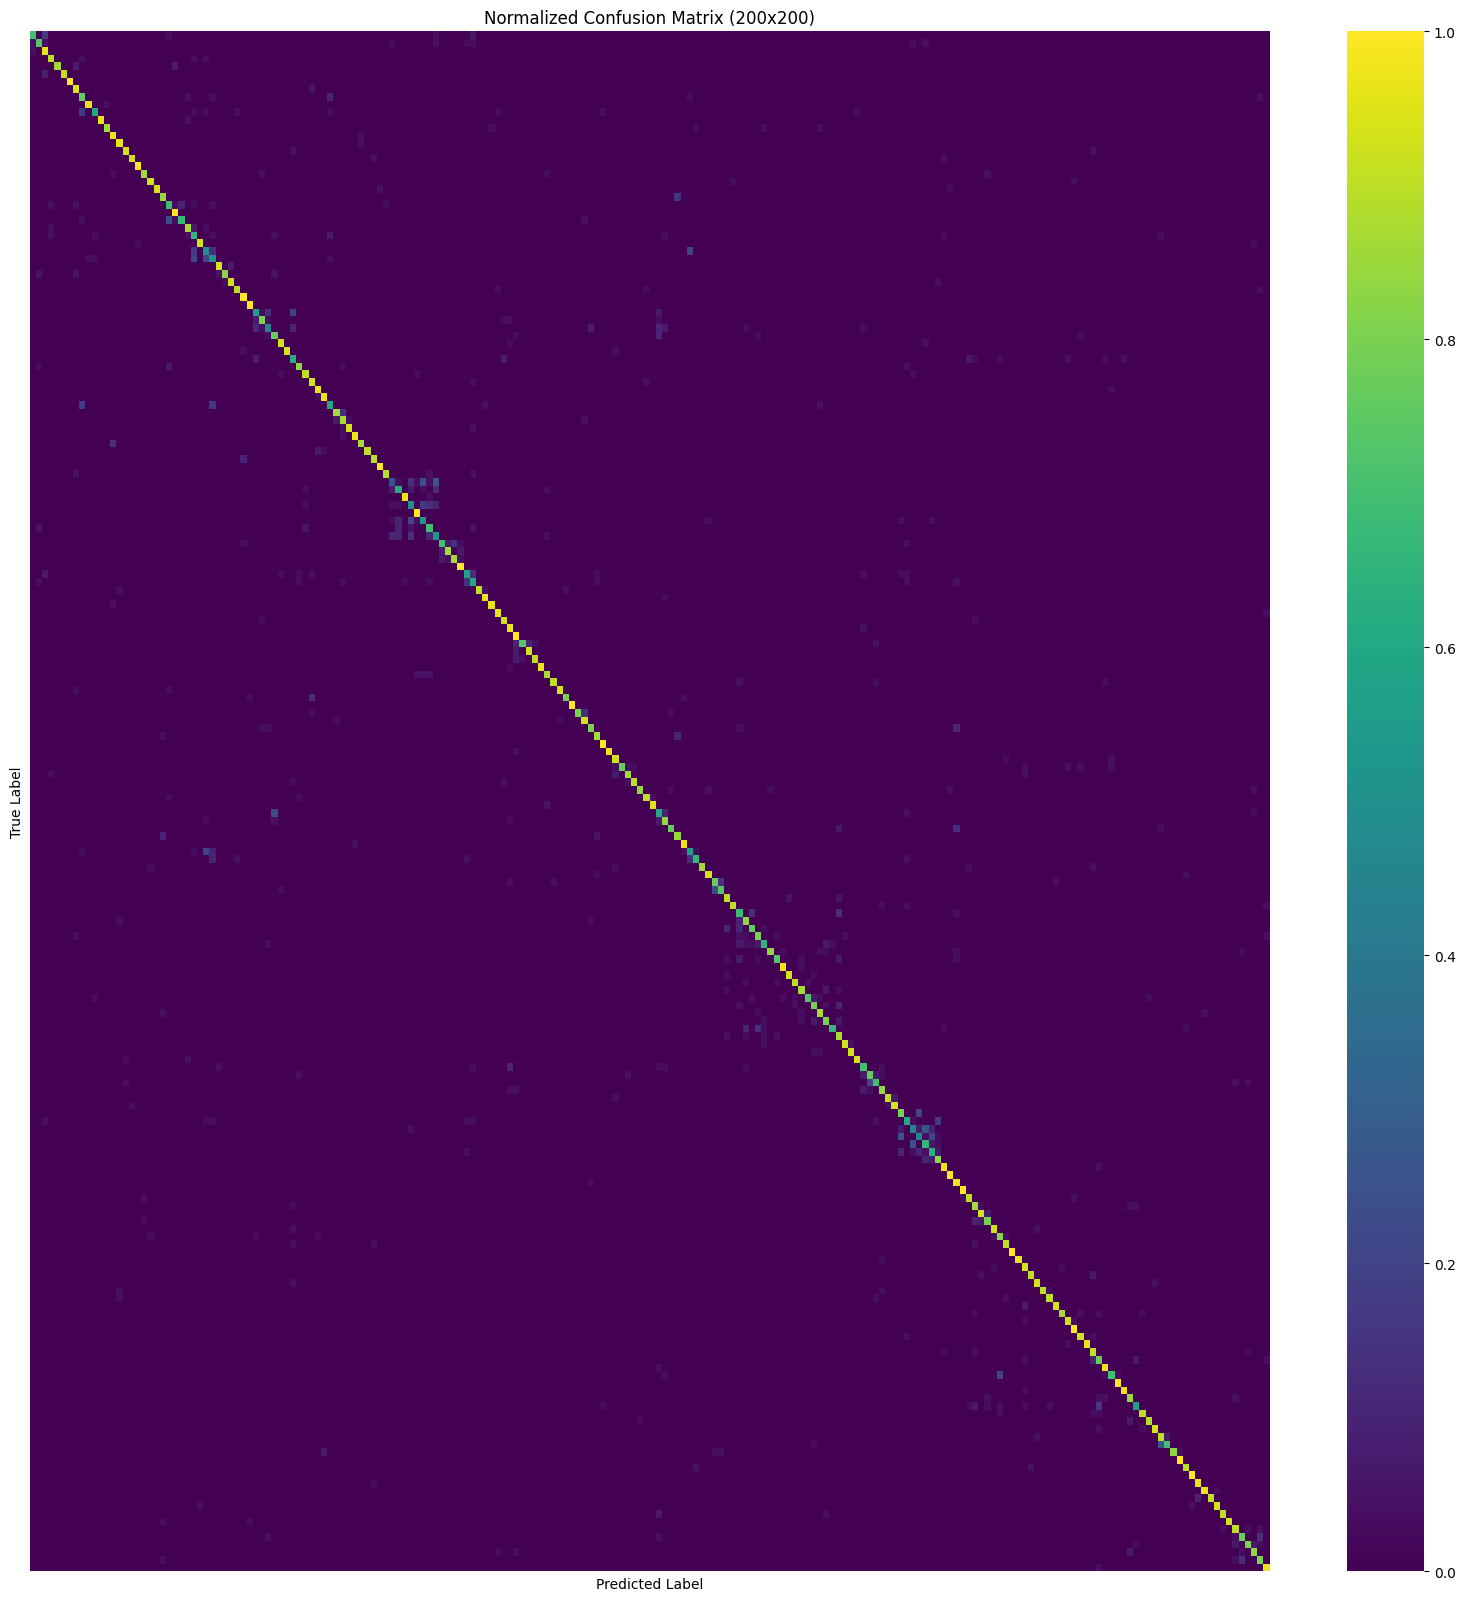

--- Top 10 Most Confused Classes ---
(True Label) -> (Predicted Label) : Percent
(California_Gull) -> (Western_Gull) : 26.67%
(Caspian_Tern) -> (Elegant_Tern) : 26.67%
(Common_Tern) -> (Artic_Tern) : 26.67%
(Louisiana_Waterthrush) -> (Northern_Waterthrush) : 26.67%
(Pelagic_Cormorant) -> (Brandt_Cormorant) : 23.33%
(California_Gull) -> (Ring_billed_Gull) : 23.33%
(Western_Wood_Pewee) -> (Olive_sided_Flycatcher) : 23.33%
(Great_Grey_Shrike) -> (Loggerhead_Shrike) : 23.33%
(Elegant_Tern) -> (Caspian_Tern) : 23.33%
(Acadian_Flycatcher) -> (Yellow_bellied_Flycatcher) : 20.69%


California_Gull        Western_Gull                 0.266667
Caspian_Tern           Elegant_Tern                 0.266667
Common_Tern            Artic_Tern                   0.266667
Louisiana_Waterthrush  Northern_Waterthrush         0.266667
Pelagic_Cormorant      Brandt_Cormorant             0.233333
California_Gull        Ring_billed_Gull             0.233333
Western_Wood_Pewee     Olive_sided_Flycatcher       0.233333
Great_Grey_Shrike      Loggerhead_Shrike            0.233333
Elegant_Tern           Caspian_Tern                 0.233333
Acadian_Flycatcher     Yellow_bellied_Flycatcher    0.206897
dtype: float64

In [7]:
plot_cm(true_labels, pred_labels)
print_confused_classes(true_labels, pred_labels, class_names=list(train_loader.dataset.class_names.values()))

In [10]:
report_dict = classification_report(
    true_labels,
    pred_labels,
    target_names=train_loader.dataset.class_names,
    output_dict=True,   
    zero_division=0
)

report_df = pd.DataFrame(report_dict).T

print("Per-class metrics (like sklearn classification_report):")
report_df


Per-class metrics (like sklearn classification_report):


,precision,recall,f1-score,support
0,0.913043,0.700000,0.792453,30.000000
1,0.846154,0.733333,0.785714,30.000000
2,0.729730,0.964286,0.830769,28.000000
3,0.870968,0.900000,0.885246,30.000000
4,1.000000,0.857143,0.923077,14.000000
...,...,...,...,...
198,0.750000,0.800000,0.774194,30.000000
199,0.878788,0.966667,0.920635,30.000000
accuracy,0.843977,0.843977,0.843977,0.843977
macro avg,0.850720,0.845732,0.844874,5794.000000


In [11]:
y_true = true_labels.numpy()
y_score = y_prob.numpy()

num_classes = y_score.shape[1]
classes = np.arange(num_classes)

# Overall scalar metrics
# One-vs-rest, macro average (average over classes)
roc_auc_macro_ovr = roc_auc_score(
    y_true, y_score,
    multi_class="ovr",
    average="macro"
)

# One-vs-rest, weighted average (weighted by support)
roc_auc_weighted_ovr = roc_auc_score(
    y_true, y_score,
    multi_class="ovr",
    average="weighted"
)

print("AUROC (macro, OVR):   ", roc_auc_macro_ovr)
print("AUROC (weighted, OVR):", roc_auc_weighted_ovr)


AUROC (macro, OVR):    0.9972138714839628
AUROC (weighted, OVR): 0.9971730848349347


In [12]:

# Binarize y_true: shape (N, C)
y_true_bin = label_binarize(y_true, classes=classes)

# Macro AUPRC (average over classes)
auprc_macro = average_precision_score(
    y_true_bin,
    y_score,
    average="macro"
)

# Micro AUPRC (treat all predictions as one big binary problem)
auprc_micro = average_precision_score(
    y_true_bin,
    y_score,
    average="micro"
)

print("AUPRC (macro):", auprc_macro)
print("AUPRC (micro):", auprc_micro)


AUPRC (macro): 0.8891033146701288
AUPRC (micro): 0.9089129074941796


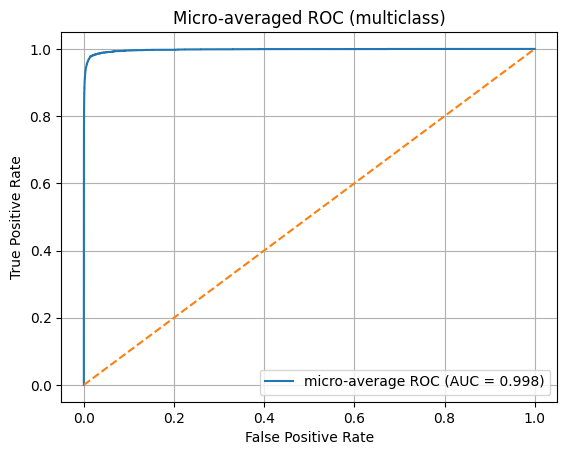

In [13]:
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"micro-average ROC (AUC = {roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged ROC (multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


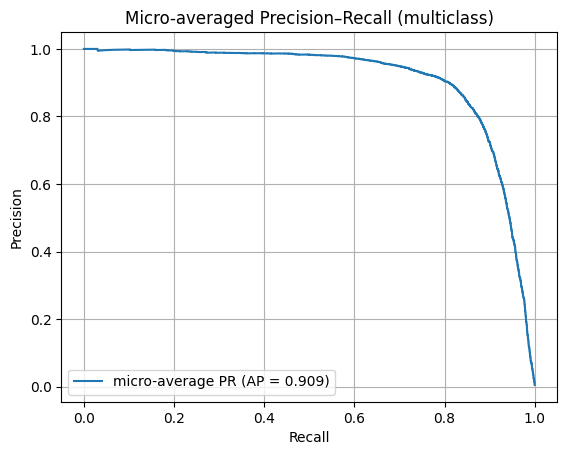

In [14]:
precision_micro, recall_micro, _ = precision_recall_curve(
    y_true_bin.ravel(),
    y_score.ravel()
)
ap_micro = average_precision_score(y_true_bin, y_score, average="micro")

plt.figure()
plt.plot(recall_micro, precision_micro,
         label=f"micro-average PR (AP = {ap_micro:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Micro-averaged Precision–Recall (multiclass)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [15]:
auroc_per_class = roc_auc_score(y_true_bin, y_score, average=None)
auprc_per_class = average_precision_score(y_true_bin, y_score, average=None)

# Map to class names
class_names = list(train_dataset.class_names.values())
for name, r, p in zip(class_names, auroc_per_class, auprc_per_class):
    print(f"{name:30s}  AUROC={r:.3f}  AUPRC={p:.3f}")


Black_footed_Albatross          AUROC=0.997  AUPRC=0.836
Laysan_Albatross                AUROC=0.997  AUPRC=0.876
Sooty_Albatross                 AUROC=1.000  AUPRC=0.903
Groove_billed_Ani               AUROC=1.000  AUPRC=0.957
Crested_Auklet                  AUROC=1.000  AUPRC=0.959
Least_Auklet                    AUROC=1.000  AUPRC=0.945
Parakeet_Auklet                 AUROC=1.000  AUPRC=1.000
Rhinoceros_Auklet               AUROC=1.000  AUPRC=0.946
Brewer_Blackbird                AUROC=0.997  AUPRC=0.715
Red_winged_Blackbird            AUROC=1.000  AUPRC=0.967
Rusty_Blackbird                 AUROC=0.990  AUPRC=0.731
Yellow_headed_Blackbird         AUROC=1.000  AUPRC=0.992
Bobolink                        AUROC=0.999  AUPRC=0.953
Indigo_Bunting                  AUROC=1.000  AUPRC=0.961
Lazuli_Bunting                  AUROC=1.000  AUPRC=0.987
Painted_Bunting                 AUROC=1.000  AUPRC=0.958
Cardinal                        AUROC=1.000  AUPRC=0.982
Spotted_Catbird                

In [16]:
import pandas as pd

df = pd.DataFrame({
    "class": class_names,
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class
})

df_sorted = df.sort_values(by="AUPRC", ascending=True)

df_sorted.head(10)

,class,AUROC,AUPRC
58,California_Gull,0.988972,0.315876
29,Fish_Crow,0.990019,0.419540
61,Herring_Gull,0.992280,0.445041
143,Common_Tern,0.992494,0.479642
28,American_Crow,0.995108,0.480699
38,Least_Flycatcher,0.989533,0.503181
145,Forsters_Tern,0.995923,0.521437
65,Western_Gull,0.994165,0.527809
63,Ring_billed_Gull,0.993876,0.537734
142,Caspian_Tern,0.994038,0.544273
